In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [3]:
"""df = pd.read_csv('mep_votes_json_final.csv', header=1)
df.head()"""

"df = pd.read_csv('mep_votes_json_final.csv', header=1)\ndf.head()"

In [4]:
"""filtered_df = df[['mep_id', 'Position', 'Party', 'Time_stamp', 'vote_id', 'Procedure_type']]
filtered_df.rename(columns={'Position': 'position', 'Party' : 'party', 'Time_stamp' : 'timestamp', 'Procedure_type' : 'procedure_type'}, inplace=True)
filtered_df.head()"""

"filtered_df = df[['mep_id', 'Position', 'Party', 'Time_stamp', 'vote_id', 'Procedure_type']]\nfiltered_df.rename(columns={'Position': 'position', 'Party' : 'party', 'Time_stamp' : 'timestamp', 'Procedure_type' : 'procedure_type'}, inplace=True)\nfiltered_df.head()"

### We are trying to make another dataframe where each row represents a party's aggregate stats on a particular vote id.

We will have the columns: party, vote_id, timestamp, num_for, num_against, num_abstention, num_no_votes, total_votes (does not include no votes), majority_col (string: for, against, or abstain (or no_votes)), majority_votes (number of votes for that party that AGREE w the majority), percent_dissent (percent of for, against, and abstain votes that agree with the MAJORITY)

We have to drop rows where the majority_col is no_votes before calculating percent dissenters

In [5]:
"""# filter only relevant vote positions
valid_positions = ['FOR', 'AGAINST', 'ABSTENTION', 'DID_NOT_VOTE']
filtered_df = filtered_df[filtered_df['position'].isin(valid_positions)]

# group and count positions by party and vote
vote_counts = (filtered_df.groupby(['vote_id', 'timestamp', 'party', 'procedure_type', 'position']).size().unstack(fill_value=0).reset_index())

# rename vote columns for clarity
vote_counts = vote_counts.rename(columns={'FOR': 'num_for', 'AGAINST': 'num_against', 
                                          'ABSTENTION': 'num_abstention', 'DID_NOT_VOTE': 'num_no_votes'})

# ensure all columns exist
for col in ['num_for', 'num_against', 'num_abstention', 'num_no_votes']:
    if col not in vote_counts.columns:
        vote_counts[col] = 0

# compute total votes (excluding no votes)
vote_counts['total_votes'] = (vote_counts['num_for'] + vote_counts['num_against'] + vote_counts['num_abstention'])

# get relevant vote cols
vote_subset = vote_counts[['num_for', 'num_against', 'num_abstention']]

# get the column with the highest value per row
vote_counts['majority_col'] = vote_subset.idxmax(axis=1).str.replace('num_', '').str.upper()

# get the max value of votes
vote_counts['majority_votes'] = vote_subset.max(axis=1)

# merge majority info back
#df_final = vote_counts.merge(majority_col, on=['vote_id', 'timestamp'])
df_final = vote_counts

# drop rows where majority_col == 'DID_NOT_VOTE'
df_final = df_final[df_final['majority_col'] != 'DID_NOT_VOTE']

# compute majority_votes for this party
def get_majority_votes(row):
    return row[f'num_{row["majority_col"].lower()}']

df_final['majority_votes'] = df_final.apply(get_majority_votes, axis=1)

# compute percent dissenters
df_final['percent_dissent'] = 1 - (df_final['majority_votes'] / df_final['total_votes'])

# optional final ordering
df_final = df_final[[
    'party', 'vote_id', 'procedure_type', 'timestamp', 'num_for', 'num_against', 'num_abstention', 'num_no_votes',
    'total_votes', 'majority_col', 'majority_votes', 'percent_dissent']]

df_final"""

'# filter only relevant vote positions\nvalid_positions = [\'FOR\', \'AGAINST\', \'ABSTENTION\', \'DID_NOT_VOTE\']\nfiltered_df = filtered_df[filtered_df[\'position\'].isin(valid_positions)]\n\n# group and count positions by party and vote\nvote_counts = (filtered_df.groupby([\'vote_id\', \'timestamp\', \'party\', \'procedure_type\', \'position\']).size().unstack(fill_value=0).reset_index())\n\n# rename vote columns for clarity\nvote_counts = vote_counts.rename(columns={\'FOR\': \'num_for\', \'AGAINST\': \'num_against\', \n                                          \'ABSTENTION\': \'num_abstention\', \'DID_NOT_VOTE\': \'num_no_votes\'})\n\n# ensure all columns exist\nfor col in [\'num_for\', \'num_against\', \'num_abstention\', \'num_no_votes\']:\n    if col not in vote_counts.columns:\n        vote_counts[col] = 0\n\n# compute total votes (excluding no votes)\nvote_counts[\'total_votes\'] = (vote_counts[\'num_for\'] + vote_counts[\'num_against\'] + vote_counts[\'num_abstention\'])\n\n#

In [6]:
# sort by party (primary) then timestamp within that?

# do i filter out rows with 0% dissent? or change them to 0.001 or smth? bc i don't know if that affects the func

In [8]:
set(df_final['party'])

NameError: name 'df_final' is not defined

In [ ]:
"""sns.set_theme(style="darkgrid")
sns.color_palette("Set2")

df_renew = df_final[df_final['party'] == 'Renew']

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_renew, x='timestamp', y='percent_dissent', label='party')

plt.xlabel('Date')
plt.ylabel('Percent Dissenters')
plt.title('Party Cohesion Over Time')
plt.legend()
plt.show()"""

'sns.set_theme(style="darkgrid")\nsns.color_palette("Set2")\n\ndf_renew = df_final[df_final[\'party\'] == \'Renew\']\n\nplt.figure(figsize=(12, 6))\nsns.lineplot(data=df_renew, x=\'timestamp\', y=\'percent_dissent\', label=\'party\')\n\nplt.xlabel(\'Date\')\nplt.ylabel(\'Percent Dissenters\')\nplt.title(\'Party Cohesion Over Time\')\nplt.legend()\nplt.show()'

In [ ]:
df_final.to_csv('time_series_data_final.csv', index=False) 

In [11]:
# on the first run, you have the relevant data saved, now you can just load it into a df each time
df_final = pd.read_csv('time_series_data_final.csv')
df_final = df_final[df_final['party'] != 'Non-attached']
df_final.head()

,party,vote_id,procedure_type,timestamp,num_for,num_against,num_abstention,num_no_votes,total_votes,majority_col,majority_votes,percent_dissent,year,month,weekday,weekofyear
0,ECR,135091,RSO,2021-07-08 15:53:14.480,62,0,0,1,62,FOR,62,0.000000,2021,7,3,27
1,EPP,135091,RSO,2021-07-08 15:53:14.480,173,0,0,5,173,FOR,173,0.000000,2021,7,3,27
2,GUE/NGL,135091,RSO,2021-07-08 15:53:14.480,39,0,0,0,39,FOR,39,0.000000,2021,7,3,27
3,Greens/EFA,135091,RSO,2021-07-08 15:53:14.480,71,0,0,2,71,FOR,71,0.000000,2021,7,3,27
4,ID,135091,RSO,2021-07-08 15:53:14.480,67,3,0,1,70,FOR,67,0.042857,2021,7,3,27


In [9]:
df_logreg = df_final[['party', 'procedure_type', 'percent_dissent']]
df_logreg.head()

,party,procedure_type,percent_dissent
0,ECR,RSO,0.000000
1,EPP,RSO,0.000000
2,GUE/NGL,RSO,0.000000
3,Greens/EFA,RSO,0.000000
4,ID,RSO,0.042857


In [28]:
df_logreg.to_csv('logistic_regression_data')

In [14]:
type(df_final['timestamp'].iloc[0])

str

In [12]:
df_final['timestamp'] = pd.to_datetime(df_final['timestamp'], format='ISO8601')
type(df_final['timestamp'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [14]:
df_time = df_final.copy()

# extract datetime features
df_time['year'] = df_time['timestamp'].dt.year
df_time['month'] = df_time['timestamp'].dt.month
df_time['weekday'] = df_time['timestamp'].dt.weekday
df_time['weekofyear'] = df_time['timestamp'].dt.isocalendar().week

# sort and enumerate unique years
sorted_years = sorted(df_time['year'].unique())
year_index_map = {year: i for i, year in enumerate(sorted_years)}

# adjust weekofyear by year index
df_time['adjusted_week'] = df_time.apply(lambda row: row['weekofyear'] + 52 * year_index_map[row['year']], axis=1)

df_time.head()

,party,vote_id,procedure_type,timestamp,num_for,num_against,num_abstention,num_no_votes,total_votes,majority_col,majority_votes,percent_dissent,year,month,weekday,weekofyear,adjusted_week
0,ECR,135091,RSO,2021-07-08 15:53:14.480,62,0,0,1,62,FOR,62,0.000000,2021,7,3,27,27
1,EPP,135091,RSO,2021-07-08 15:53:14.480,173,0,0,5,173,FOR,173,0.000000,2021,7,3,27,27
2,GUE/NGL,135091,RSO,2021-07-08 15:53:14.480,39,0,0,0,39,FOR,39,0.000000,2021,7,3,27,27
3,Greens/EFA,135091,RSO,2021-07-08 15:53:14.480,71,0,0,2,71,FOR,71,0.000000,2021,7,3,27,27
4,ID,135091,RSO,2021-07-08 15:53:14.480,67,3,0,1,70,FOR,67,0.042857,2021,7,3,27,27


In [15]:
df_time.to_csv('time_db_data')

In [17]:
list(set(df_time['year']))

[2021, 2022, 2023, 2024, 2025]

In [18]:
len(list(set(df_time['procedure_type'])))

15

In [19]:
df_time[df_time['party'] == 'ECR'].head()

,party,vote_id,procedure_type,timestamp,num_for,num_against,num_abstention,num_no_votes,total_votes,majority_col,majority_votes,percent_dissent,year,month,weekday,weekofyear,adjusted_week
0,ECR,135091,RSO,2021-07-08 15:53:14.480,62,0,0,1,62,FOR,62,0.000000,2021,7,3,27,27
7,ECR,135092,RSP,2021-07-08 15:53:14.480,1,0,0,0,1,FOR,1,0.000000,2021,7,3,27,27
14,ECR,135148,COD,2021-09-13 21:08:45.000,38,23,1,1,62,FOR,38,0.387097,2021,9,0,37,37
21,ECR,135150,COD,2021-09-15 15:22:30.000,59,4,0,0,63,FOR,59,0.063492,2021,9,2,37,37
28,ECR,135154,COD,2021-09-15 15:22:30.000,35,11,17,0,63,FOR,35,0.444444,2021,9,2,37,37


In [20]:
df_time.shape

(10074, 17)

In [21]:
len(set(df_time['vote_id']))
# cross validate model
# add interaction effects
# cross validate

# potential: look into moving averages time series model using package

1417

In [ ]:
"""df_no_zeros = df_time[df_time['percent_dissent'] != 0]
df_no_zeros"""

In [22]:
def logistic_regression(X, y, w, alpha=1, max_iter=None):
    runalg = True
    i = 0
    iter = 0
    
    while runalg:
        x = X[i, :]
        yhat = 1 / (1 + np.exp(-np.dot(x, w)))

        w = w - alpha * (yhat - y[i]) * x
        i += 1

        if i == len(y):
            i = 0
            iter += 1

        if max_iter is not None and iter == max_iter:
            runalg = False
            print(f"Algorithm reached max_iter, final w = {w}")
            print(f"Total number of iterations = {iter}")
    
    return w

X_np = sm.add_constant(pd.get_dummies(df_time[['party', 'procedure_type']], drop_first=True)).astype(float).values

#y_np = df_time['percent_dissent'].values
# this one prevents us from having values of percent dissent that are exactly 0 or 1
y_np = df_time['percent_dissent'].clip(lower=0.00001, upper=0.999).values

#w = np.random.randn(X_np.shape[1])
#w_final = logistic_regression(X_np, y_np, w, alpha=0.007, max_iter=3000)

#y_pred = 1 / (1 + np.exp(-np.dot(X_np, w_final)))
#_pred_percent = y_pred * 100
#y_true_percent = y_np * 100

#r2 = r2_score(y_true_percent, y_pred_percent)
#print(f"R2 score: {r2}")

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)
w_init = np.random.randn(X_train.shape[1])
w_trained = logistic_regression(X_train, y_train, w_init, alpha=0.007, max_iter=3000)
y_test_pred = 1 / (1 + np.exp(-np.dot(X_test, w_trained)))
y_pred_percent = y_test_pred * 100
y_true_percent = y_test * 100

r2 = r2_score(y_true_percent, y_pred_percent)
print(f"R2 score: {r2}")

Algorithm reached max_iter, final w = [-2.07829316 -1.22759572 -0.69195234 -0.03461627 -2.09729848  0.51337231
  0.0846254  -1.34616326 -1.94762885  0.84483474  0.35575192  1.09197896
  0.36326028  0.48905638  0.72452503  0.20695639  0.75508881  0.73206426
  0.35972769  0.12725121  1.11482283  0.0368592   0.73963145]
Total number of iterations = 3000
R2 score: 0.33462876048646395


In [ ]:
"""print(len(y_pred_percent), len(y_np))
print(y_pred_percent[0], y_np[0])
resids = y_pred_percent - (y_np * 100)
resids.mean()"""

2015 10074
2.4446087147235094 1e-05


ValueError: operands could not be broadcast together with shapes (2015,) (10074,) 

In [ ]:
print(set(df_no_zeros['adjusted_week']))
df_groupbyweek = df_no_zeros.groupby(['adjusted_week', 'party'])['percent_dissent'].mean().reset_index()
df_groupbyweek.head(10)

{128, 132, 141, 144, 146, 149, 151, 154, 27, 159, 162, 37, 165, 167, 40, 42, 171, 45, 173, 47, 50, 55, 185, 59, 61, 62, 64, 66, 194, 197, 70, 199, 72, 202, 75, 204, 77, 79, 207, 212, 215, 89, 219, 92, 94, 222, 97, 99, 227, 229, 102, 107, 109, 111, 115, 117, 120, 123, 126}


,adjusted_week,party,percent_dissent
0,27,ID,0.042857
1,37,ECR,0.193555
2,37,EPP,0.121920
3,37,GUE/NGL,0.196725
4,37,Greens/EFA,0.043188
5,37,ID,0.234017
6,37,Renew,0.071429
7,37,S&D,0.090797
8,40,ECR,0.156036
9,40,EPP,0.109638


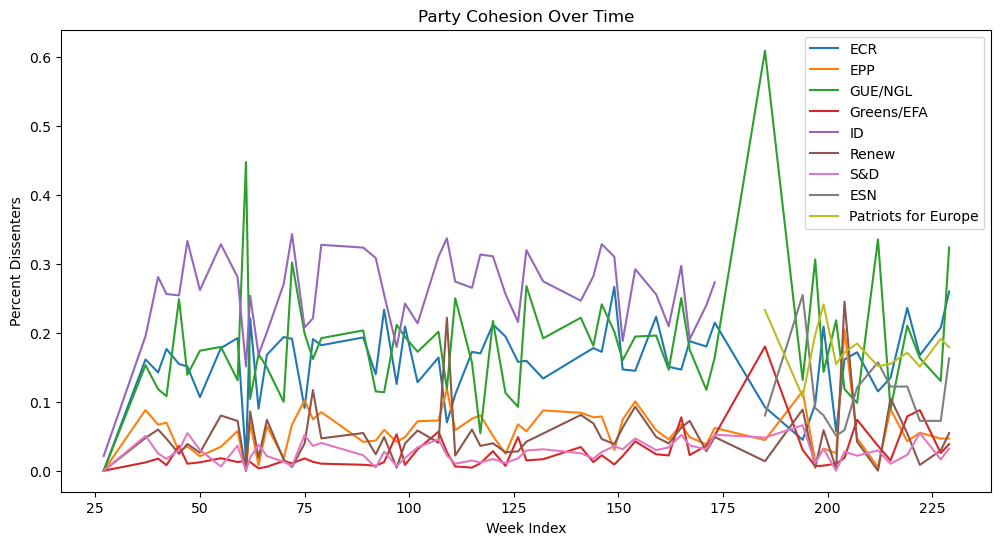

In [ ]:
plt.figure(figsize=(12, 6))
for party in df_time['party'].unique():
    party_df = df_time[df_time['party'] == party]
    sns.lineplot(data=party_df, x='adjusted_week', y='percent_dissent', label=party, errorbar=None)

plt.xlabel('Week Index')
plt.ylabel('Percent Dissenters')
plt.title('Party Cohesion Over Time')
plt.legend()
plt.show()

In [ ]:
df_time[df_time['percent_dissent'] > 0.6].head()

,party,vote_id,procedure_type,timestamp,num_for,num_against,num_abstention,num_no_votes,total_votes,majority_col,majority_votes,percent_dissent,year,month,weekday,weekofyear,adjusted_week
106,EPP,135749,RSP,2021-09-16 15:48:43,53,55,66,5,174,ABSTENTION,66,0.620690,2021,9,3,37,37
242,ID,136004,INI,2021-10-06 22:49:29,27,25,18,0,70,FOR,27,0.614286,2021,10,2,40,40
417,ID,136905,RSP,2021-10-21 11:52:25,24,22,24,0,70,FOR,24,0.657143,2021,10,3,42,42
578,ID,137566,RSP,2021-11-25 15:36:34,24,23,20,3,67,FOR,24,0.641791,2021,11,3,47,47
795,ID,138178,RSP,2021-12-16 15:32:12,27,26,15,2,68,FOR,27,0.602941,2021,12,3,50,50


In [7]:
set(df_logreg['procedure_type'])

{'ACI',
 'APP',
 'BUD',
 'BUI',
 'CNS',
 'COD',
 'DEA',
 'DEC',
 'INI',
 'INL',
 'NLE',
 'REG',
 'RPS',
 'RSO',
 'RSP'}

In [ ]:
y_pred_percent

array([3.35039950e+00, 1.01426743e-08, 6.23269332e+00, ...,
       9.99999995e+01, 8.82432455e-14, 2.15735838e-11])

In [ ]:
# i could average all the dissents for each 'cluster' (we could group votes that happen in the same week and see how that goes)
# and use that as a datapoint, then the features would be clutser index